In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, h5py
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

os.environ["OMP_NUM_THREADS"] = str(len(os.sched_getaffinity(0)))
import healpy as hp

from scipy.signal import savgol_filter
from tqdm import tqdm

from msfm.utils import tfrecords, files, parameters, scales, lensing, observation, maps
from msfm.fiducial_pipeline import FiducialPipeline
from msfm.utils.input_output import read_yaml

from msi.utils import preprocessing, plotting, input_output

tf.config.experimental.set_memory_growth(tf.config.list_physical_devices(device_type="GPU")[0], True)

24-06-06 08:18:44   imports.py INF   Setting up healpy to run on 256 CPUs 
24-06-06 08:18:44   imports.py INF   Setting up healpy to run on 256 CPUs 
24-06-06 08:18:44   imports.py INF   Setting up healpy to run on 256 CPUs 
24-06-06 08:18:44   imports.py INF   Setting up healpy to run on 256 CPUs 


In [3]:
conf = "/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v9/linear_bias.yaml"
# conf = "/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v9/linear_bias_no_smoothing.yaml"
conf = files.load_config(conf)

n_side = 512
n_pix = hp.nside2npix(n_side)
# data_vec_pix, _, _, _ = files.load_pixel_file(conf)

n_z = 8
l_min_global = 30
l_max_global = 3 * n_side - 1

In [4]:
fidu_pipe = FiducialPipeline(
    conf=conf,
    params=[],
    with_lensing=True,
    with_clustering=True,
    with_padding=True,
    # with_padding=False,
    apply_norm=False,
    # apply_norm=True,
    shape_noise_scale=1.0,
    poisson_noise_scale=1.0,
)

n_side = conf["analysis"]["n_side"]
n_pix = hp.nside2npix(n_side)
data_vec_pix = fidu_pipe.data_vec_pix
# patch_pix = fidu_pipe.patch_pix
n_z = fidu_pipe.n_z_metacal + fidu_pipe.n_z_maglim
l_max_global = 3 * n_side - 1

24-06-06 08:18:45     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_512.h5 
24-06-06 08:18:45     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_512.h5 


In [5]:
fidu_dset = fidu_pipe.get_dset(
    tfr_pattern="/pscratch/sd/a/athomsen/DESY3/v8/linear_bias/tfrecords/fiducial/DESy3_fiducial_dmb_????.tfrecord",
    # tfr_pattern="/pscratch/sd/a/athomsen/DESY3/v8/linear_bias_no_smoothing/tfrecords/fiducial/DESy3_fiducial_dmb_????.tfrecord",
    local_batch_size=1,
    noise_indices=10,
    n_readers=1,
    examples_shuffle_buffer=None,
    n_prefetch=2,
    is_eval=True,
)

for dv, index in fidu_dset.take(1):
    pass

print(dv.shape)

24-06-06 08:18:47 fiducial_pip WAR   Evaluation mode is activated: the random seed is fixed, the shuffle arguments ignored, and the dataset is not repeated 
24-06-06 08:18:47 fiducial_pip INF   n_workers is not set, using tf.data.AUTOTUNE. This might produce unexpected RAM usage. 
24-06-06 08:18:47 fiducial_pip INF   drop_remainder is not set, using drop_remainder = False 
24-06-06 08:18:47 fiducial_pip INF   Including noise_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
24-06-06 08:18:47 fiducial_pip INF   Interleaving with n_readers = 1 
24-06-06 08:18:48 fiducial_pip INF   Batching into 1 elements locally with drop_remainder = False 
24-06-06 08:18:49 fiducial_pip WAR   Tracing _augmentations 
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warnin

(3145728, 4, 2)
(3145728, 4)


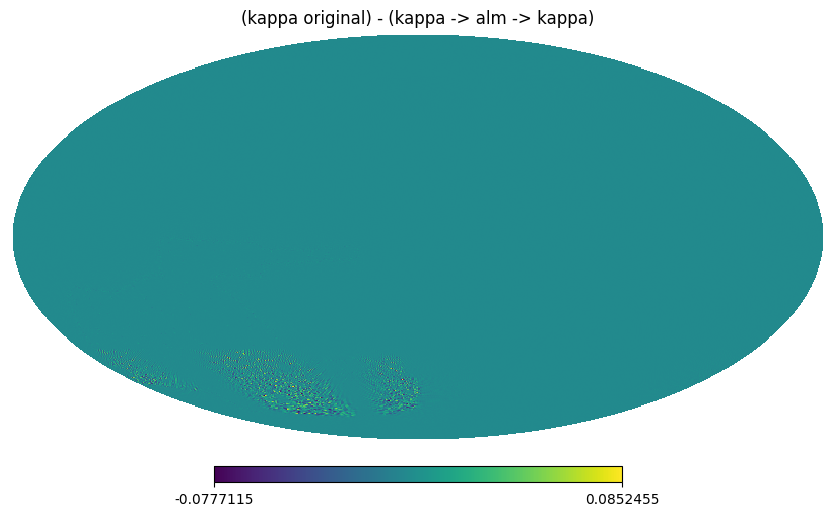

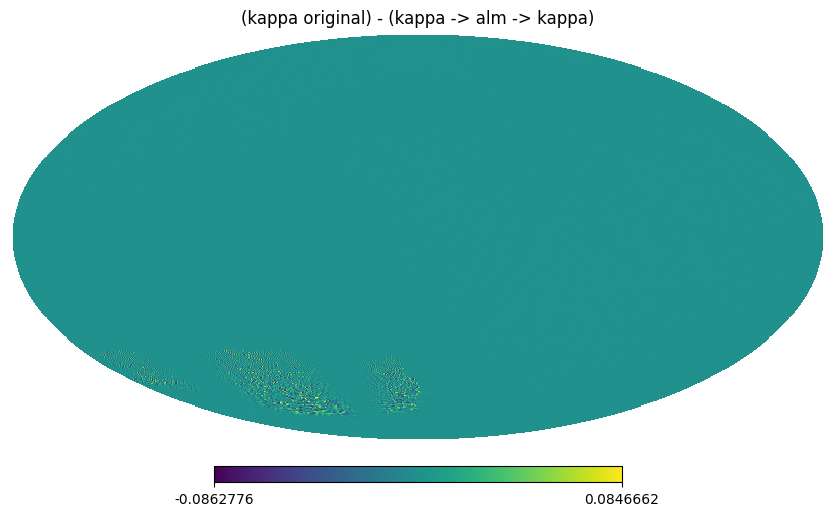

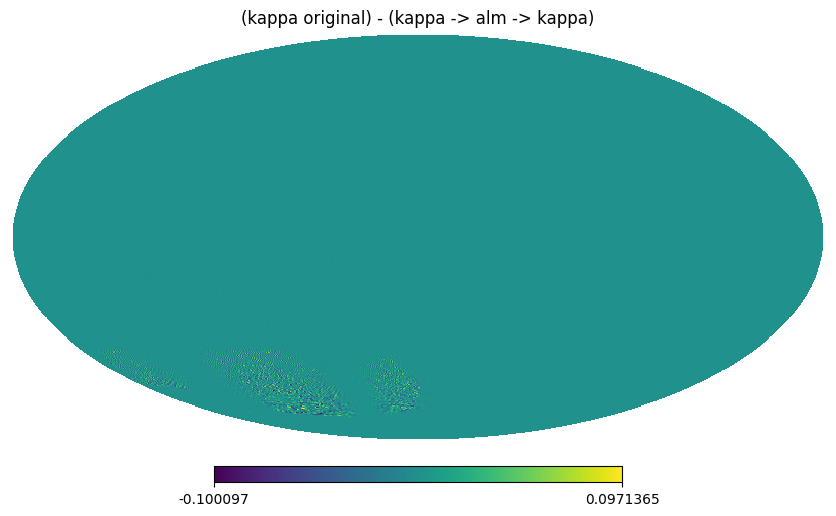

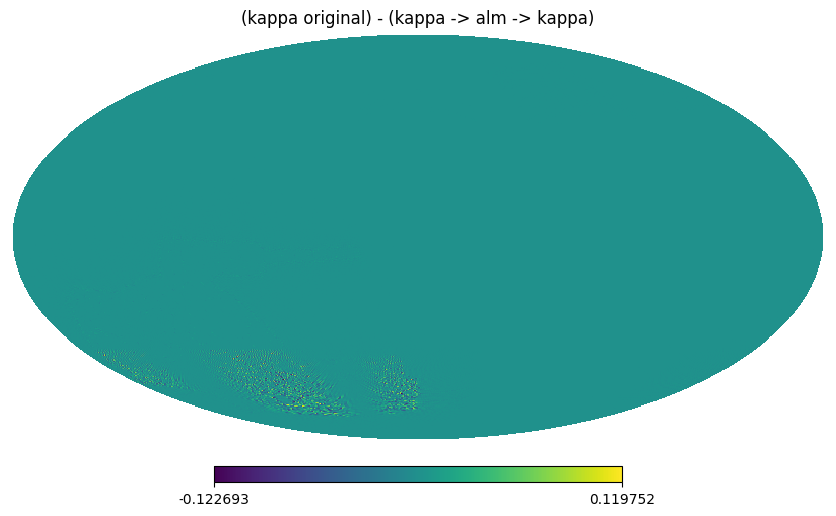

In [6]:
# weak lensing
n_metacal = 4

wl_kappa = np.zeros((n_pix, n_metacal))
wl_kappa[data_vec_pix] = dv[0,:,:n_metacal]

kappa2gamma_fac, gamma2kappa_fac, _ = lensing.get_kaiser_squires_factors(3*n_side-1)

wl_gamma = np.zeros((n_pix, n_metacal, 2))
for i in range(n_metacal):
    kappa_alm = hp.map2alm(
        hp.reorder(wl_kappa[...,i], n2r=True),
        # use_pixel_weights=True,
        # datapath="/global/u2/a/athomsen/multiprobe-simulation-forward-model/data/healpy_data"
    )
    
    # the artifacts are actually due to going from map -> alm and back
    kappa_to_alm_to_kappa = hp.alm2map(kappa_alm, nside=n_side)
    hp.mollview(hp.reorder(wl_kappa[...,i], n2r=True) - kappa_to_alm_to_kappa, title="(kappa original) - (kappa -> alm -> kappa)")

    gamma_alm = kappa_alm * kappa2gamma_fac
    _, wl_gamma[:,i,0], wl_gamma[:,i,1] = hp.alm2map(
        [np.zeros_like(gamma_alm), gamma_alm, np.zeros_like(gamma_alm)], nside=n_side
    )
    
    # hp.mollview(wl_gamma[:,i,0], nest=True)
    
wl_gamma[...,0] = maps.tomographic_reorder(wl_gamma[...,0], r2n=True)
wl_gamma[...,1] = maps.tomographic_reorder(wl_gamma[...,1], r2n=True)

print(wl_gamma.shape)

# galaxy clustering
n_maglim = 4

gc_count = np.zeros((n_pix, n_maglim))
gc_count[data_vec_pix] = dv[0,:,n_maglim:]
print(gc_count.shape)

In [7]:
dv_obs = observation.forward_model_observation_map(
    wl_gamma_map=wl_gamma.copy(),
    gc_count_map=gc_count.copy(),
    conf=conf,
    apply_norm=False,
    with_padding=True,
    nest=True
)
print(dv_obs.shape)

24-06-06 08:19:13     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_512.h5 
24-06-06 08:19:13     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_512.h5 
(464896, 8)


In [8]:
obs_map = np.zeros((n_pix, n_z))
obs_map[data_vec_pix] = dv_obs

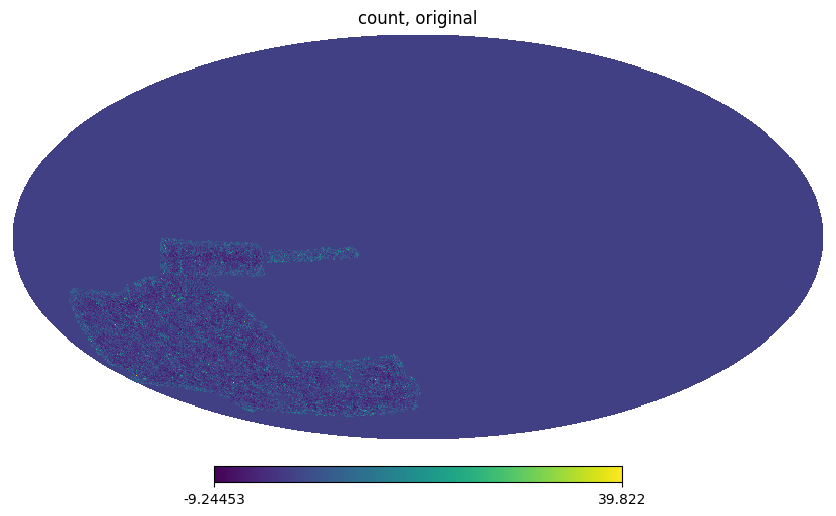

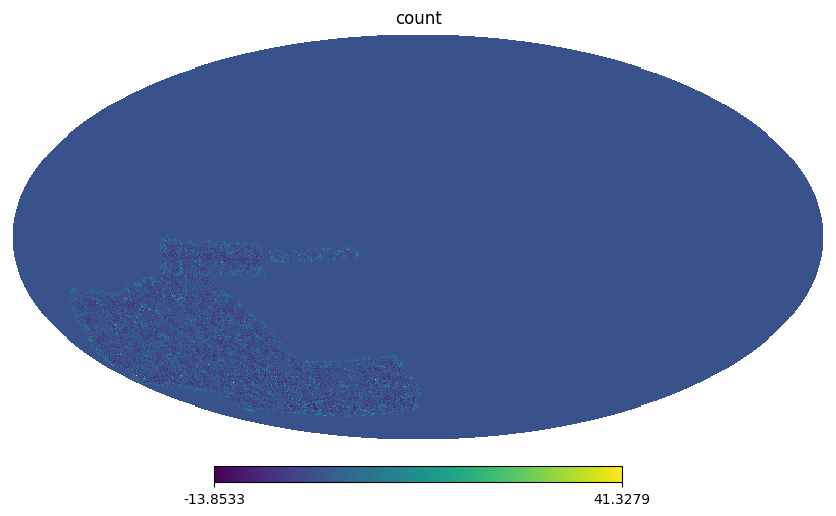

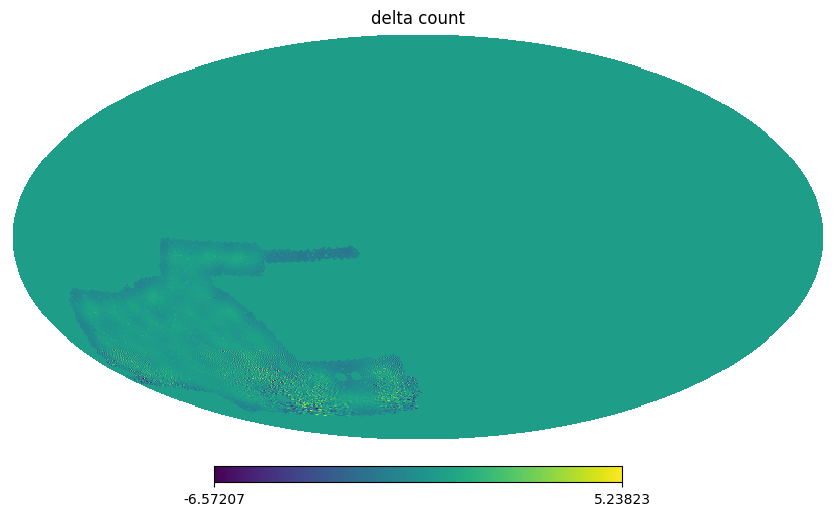

In [9]:
i_z = 0

hp.mollview(gc_count[:,i_z], title="count, original", nest=True)
hp.mollview(obs_map[:,i_z+4], title="count", nest=True)
hp.mollview(obs_map[:,i_z+4] - gc_count[:,i_z], title="delta count", nest=True)

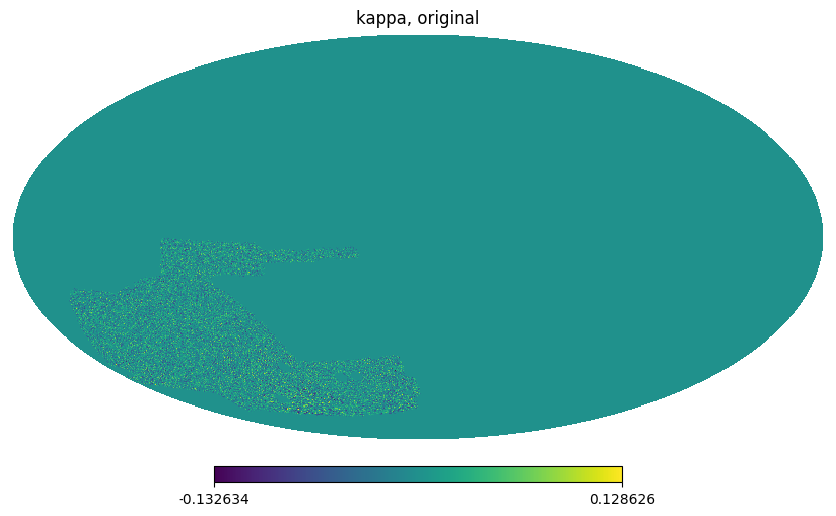

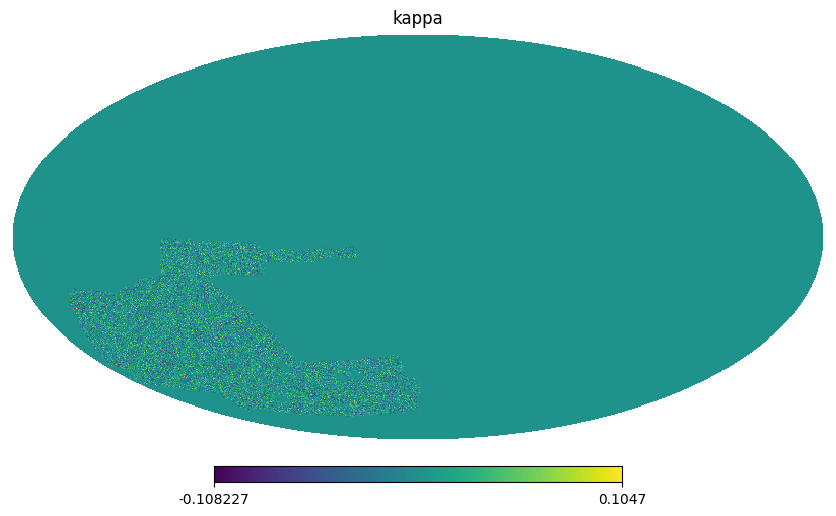

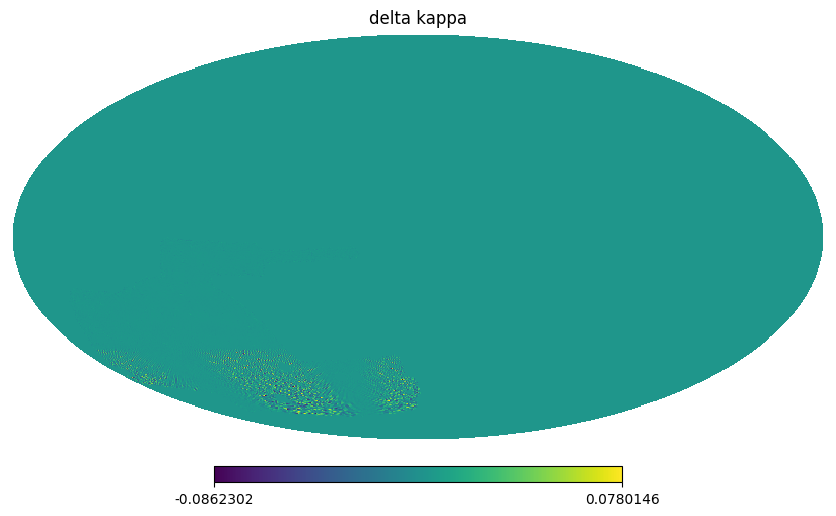

In [10]:
i_z = 0

hp.mollview(wl_kappa[:,i_z], title="kappa, original", nest=True)
hp.mollview(obs_map[:,i_z], title="kappa", nest=True)
hp.mollview(obs_map[:,i_z] - wl_kappa[:,i_z], title="delta kappa", nest=True)

In [11]:
# i_z = 0

# hp.mollview(obs_map[:,i_z], title="kappa", nest=True)
# hp.mollview(obs_map[:,i_z+4], title="count", nest=True)

# hp.mollview(obs_map[:,i_z] - wl_kappa[:,i_z], title="delta kappa", nest=True)
# hp.mollview(obs_map[:,i_z+4] - gc_count[:,i_z], title="delta count", nest=True)